Notebook 3, Module 1, Data and Data Management, CAS Applied Data Science, 2019-08-23, S. Haug, University of Bern. 

# 3. Data acquisition on the world wide web

**Learning outcomes:**

Participants will be able to collect data from www sources. Examples are provided and exercised.


**Further sources**
- Examples all over internet
- A book: https://www.packtpub.com/big-data-and-business-intelligence/mastering-social-media-mining-python


## 3.1 Analyse Aare with data from https://aareguru.existenz.ch/



Get the data from website, bring it into a format which can be imported into a dataframe, plot the time series and the histograms.

In [2]:
from urllib.request import urlopen
import pandas as pd
import matplotlib
startlink = "https://aareguru.existenz.ch/v2018/current"
f = urlopen(startlink)
l = str(f.read())
l=l.split('[')[3].split(']')
l='['+l[0]+']'
#print(l)
df = pd.read_json(l)
df.head()
#df


,timestamp,flow,temperature
0,2020-08-01 18:00:00,181,21.79
1,2020-08-01 18:10:00,181,21.77
2,2020-08-01 18:20:00,181,21.75
3,2020-08-01 18:30:00,180,21.73
4,2020-08-01 18:40:00,180,21.71


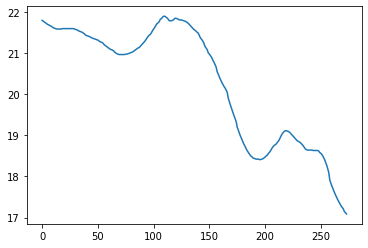

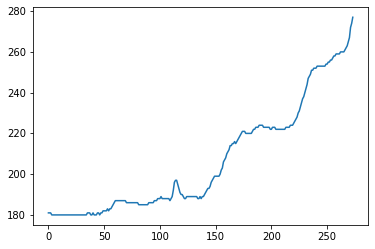

In [3]:
import matplotlib.pyplot as plt
df['temperature'].plot()
plt.show()
df['flow'].plot()

Are flow and temperature correlated on this day? Let's look at the scatter plots.

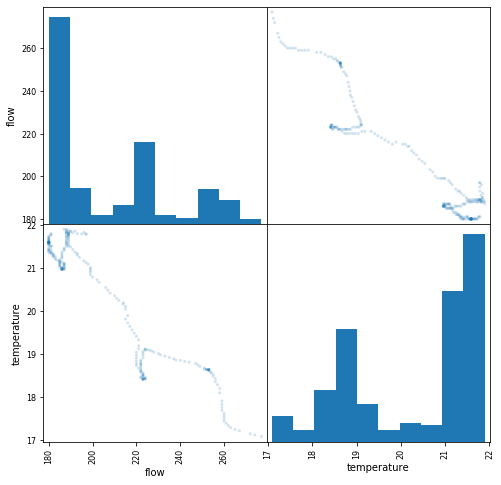

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(8, 8), diagonal='hist')
plt.show()

There seems to be a quite complicated correlation, if at all. Let's look at the summary statistics.

In [5]:
df.describe()

,flow,temperature
count,274.000000,274.000000
mean,206.795620,20.268431
std,27.055807,1.436791
min,180.000000,17.090000
25%,186.000000,18.780000
50%,192.000000,21.000000
75%,223.000000,21.557500
max,277.000000,21.890000


**Possible further exercise or project for Module 1 and 2**

Find some colleague who can the historical data (use the API) out of https://aareguru.existenz.ch/. Bring all data into one data frame. Look for correlations, averages (per month, per year ...). Combine the data with weather data, e.g. the wind on the Thun lake. For the Model 2 project, make a model predicting the Aare temperature. 

## 3.2 Get pictures (or files) from webpages

Get a picture a show it directly.

In [ ]:
from IPython.display import Image as image
from IPython.display import display

url = 'http://web.lhep.unibe.ch/shaug/lar/numuqe/evd.planeview.00001.000000001.png'
img = image(url=url)
display(img)

Download a file into the current directory (for further processing). In this exmple we downloud a file with tweets from the present US president. Then we load it into a dataframe for some analysis.

In [ ]:

import urllib
fname="http://web.lhep.unibe.ch/shaug/tmp/t-tweets.txt"
urllib.request.urlretrieve(fname,'t-tweets.txt')
df = pd.read_json('t-tweets.txt')
df.head()


In [ ]:
df.info()

Let's check how often Obama was mentioned in these 245 tweets.

In [ ]:
counter=0
txt = df['text']
for i in range(0,len(txt)):
    if 'Obama' in txt[i]: counter+=1
print(counter)

(Yes, these are prefiltered tweets about Obama)

## 3.2 Scrape Webpages (html scraping)

There are almost two billion online websites. With python you can easily read and parse this data if you have the links. Here we get the links on the landing page of Science IT Suport, and if there are any, the mail addresses. 
 

In [ ]:
from urllib.request import urlopen
import pandas as pd

#startlink = "http://www.scits.unibe.ch"
startlink = "http://www.scits.unibe.ch/about_us/contact/"
f = urlopen(startlink)
myfile = f.read()
lines = str(myfile).split(' ')
links = []
addresses = []
for line in lines:
    if 'http' in line:
        links.append(line)
    elif '@' in line:
        #print(line)
        addresses.append(line)
df_links = pd.DataFrame(links,columns=['Links'])
df_addrs = pd.DataFrame(addresses,columns=['Adresses'])
df_addrs

The above code is not optimal as you have probably seen. Lets use regular expressions instead (from StackOverflow). Regular expressions are a bit geeky, but very powerful and great fun. If you don't wan't to learn them, you mostly find the expression you want by googling. 

In [ ]:
import re # the regular expression module
startlink = "http://www.scits.unibe.ch/about_us/contact/"
f = urlopen(startlink)
html = f.read()
# Extract email addresses
reobj = re.compile(r"\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,6}\b", re.IGNORECASE)
print(re.findall(reobj, html.decode('utf-8')))
# Extract urls (links)
urls = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', html.decode('utf-8'))
print(urls)

### Possible exercise

Hier a nice little challenge for you. Use the code above (together with a for loop or two) to scrape all webpages of your employer company for public available email addresses and put them into a dataframe :) (of course you could scrape all internet now, but we don't go that far today).

In [ ]:
# Write, copy and paste your code here


### Tables from webpages

If you or someone else pubslishes data in html tables, it can be collected with pandas quite easily, actually directly without using the urllib module.

In [ ]:
import pandas as pd
#link = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"
link = "https://en.wikipedia.org/wiki/List_of_countries_by_electricity_consumption"
tables = pd.read_html(link)
df = tables[0]
df.head()

In which countries are the people consuming the most?

In [ ]:
df.info()

In [ ]:
s_df = df.iloc[1:,1:2] 
s_df['consum'] = df.iloc[1:,7].astype('float')
s_df.sort_values('consum', ascending=False)

In [2]:
s_df['consum'].plot(kind='hist',bins=50,range=(1000,50000))

NameError: name 's_df' is not defined

## 3.3 Run cron jobs (linux) / scheduled tasks (windows)

If you need to collect data on a regular basis you typically run a so-called cron job on a Linux machine or a scheduled task on a Windows machine. For example, you can specify when and how often your Python data acquisition script should run. Maybe you would like to collect new Aare data every day. Of course, your computer has to be running and connected to internet if you collect data from internet.

Here an example collecting Aare data. The python script aarecollect.py:

In [8]:
import urllib
import datetime
link = "https://aareguru.existenz.ch/v2018/current"
filename = 'aare-data-'+ str(datetime.date.today()) +'.json'
urllib.request.urlretrieve(link,filename)



('aare-data-2019-08-23.json', <http.client.HTTPMessage at 0x104397828>)

On Linux you specify when to execute this file and how often in the so called crontab. On Windows by configuring a Scheduled Task. Google instructions if you need to do this.

### 5. Access data bases via Python (mysql)

You can access data bases with appropriate APIs from Python and also the Jupyter notebooks. One very popular type of database is mysql. Install the API module:

pip install mysql-connector-python-rf

If we have acces to a machine with a database, we can connect database and retrieve data to analyse.


In [ ]:
import mysql.connector

#cnx = mysql.connector.connect(user='scott', password='password',
#                              host='mycomputer.unibe.ch',
#                              database='employees')
#cnx.close()

See examples on how to create tables, fill and query them in the manual: https://dev.mysql.com/doc/connector-python/en/connector-python-examples.html

# The follwing examples are not working, but indicates how one could data in different ways from social media

### 2. Google search

There is are APIs for doing google searches from Python. Hier is one explained. 

https://stackoverflow.com/questions/37083058/programmatically-searching-google-in-python-using-custom-search

However, we didn't get it tp work right away. Maybe we used wrong key and id? 

If you need this, you will have to figure it out yourself.  

In [ ]:
from googleapiclient.discovery import build
import pprint

In [ ]:
my_api_key = "" #"Google API key"
my_cse_id = ""

#def google_search(search_term, api_key, cse_id, **kwargs):
    
#service = build("customsearch", "v1", developerKey=my_api_key)
#res = service.cse().list(q='sigve haug', cx=my_cse_id, **kwargs).execute()
#res = service.cse().list(q='sigve haug', cx=my_cse_id).execute()
#    return res['items']

#results = google_search('stackoverflow site:en.wikipedia.org', my_api_key, my_cse_id, num=10)
#for result in results:
#    pprint.pprint(result)

### 3. Twitter

**Note:** This example we couldn't execute because Twitter didn't yet approve the application request.

Twitter generates about 500M tweets per day. Thus, data mining on twitter can be interesting.

Note: there are rate limits in the use of the Twitter API, as well as limitations in case you want to provide a downloadable data-set, see:

https://dev.twitter.com/overview/terms/agreement-and-policy

https://dev.twitter.com/rest/public/rate-limiting

Tweepy is one python module with clients for thwe Twitter API. Install it from your terminal/console:

- pip install tweepy==3.3.0

Now we need some login information from Twitter. So we must register an application. 

Point your browser to http://apps.twitter.com, log-in to Twitter (if you’re not already logged in) and register a new application. You can now choose a name and a description for your app (for example “Mining Demo” or similar). You will receive a consumer key and a consumer secret: these are application settings that should always be kept private. From the configuration page of your app, you can also require an access token and an access token secret. Similarly to the consumer keys, these strings must also be kept private: they provide the application access to Twitter on behalf of your account. The default permissions are read-only, which is all we need in our case, but if you decide to change your permission to provide writing features in your app, you must negotiate a new access token.

In [ ]:
import tweepy
from tweepy import OAuthHandler
 
consumer_key = 'YOUR-CONSUMER-KEY'
consumer_secret = 'YOUR-CONSUMER-SECRET'
access_token = 'YOUR-ACCESS-TOKEN'
access_secret = 'YOUR-ACCESS-SECRET'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

### 4. Instagram

Largest photo sharing social media platform with 500 million monthly active users, and 95 million pictures and videos uploaded on Instagram daily. 

We need an Instagram API. From the command line :

`python -m pip install -e git+https://github.com/LevPasha/Instagram-API-python.git#egg=InstagramAPI`

And we need ffmpeg. We can get it like this:


In [ ]:
import imageio
imageio.plugins.ffmpeg.download()


Logging in to Instagram Using the API. The login process takes some seconds and then returns a success message if successful.

In [ ]:
from InstagramAPI import InstagramAPI
username="sigvehaugbern" # sigvehaugbern
InstagramAPI = InstagramAPI(username, <password>) # 
InstagramAPI.login()

In [ ]:
InstagramAPI.getProfileData()
result = InstagramAPI.LastJson

In [ ]:
print (result['status'])

In [ ]:
InstagramAPI.timelineFeed()

In [ ]:
res = InstagramAPI.LastJson

In [ ]:
res

### Show the pictures from your account in the Jupyter notebook

In the above json dictionary we have the link to the images. We can display them like this:

In [ ]:
from IPython.display import Image as image
from IPython.display import display

url = 'https://instagram.fqls1-1.fna.fbcdn.net/vp/a881379f7a5d9ada39e60dd5791344a7/5C0DA510/t51.2885-15/sh0.08/e35/s750x750/39026032_683146402062694_5636277589606662144_n.jpg?ig_cache_key=MTg0NzI1ODEwNjE1ODA2NDU1OA%3D%3D.2'

img = image(url=url)
display(img)

https://www.kdnuggets.com/2017/08/instagram-python-data-analysis.html

In Module 3 you may do as project deep learning on pictures. Can you teach your deep neural network to distinguish a human from a pig? Or a male human face from a female human face? Instagram could be a source of pictures, e.g. by hash tags. If you do supervised learning, the annotation of the pictures is the larger job.   

# Last word

The power is yours. 

